In [1]:
#importing libraries

import os
import numpy as np
import torch
import time
import torch.utils.data
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import cv2
import glob
from PIL import Image
import ntpath
import os
from tqdm import tqdm
from tqdm import trange
%matplotlib inline

In [2]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

lr = 0.01 
epochs=20
device = 'cuda'
train_batch_size = 128
test_batch_size = 128
ACLASSES = ('buildings', 'forest', 'glacier', 'mountain', 'sea', 'street')

### DATASET CLASS

In [3]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.transform = transform
        self.classes = os.listdir(data_folder)
        self.class_to_idx = {'buildings':0,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}
        self.samples = self.make_dataset()
        
    def make_dataset(self):
        samples = []
        for target_class in self.classes:
            class_index = self.class_to_idx[target_class]
            target_dir = os.path.join(self.data_folder, target_class)
            target_files = os.listdir(target_dir)
            for file in target_files:
                path = os.path.join(target_dir, file)
                samples.append((path, class_index))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = Image.open(path)
        
        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

### INITIALISE THE DATASET and THE DATALOADERS 

In [4]:

START_seed()
# Define your transformations
train_transform = transforms.Compose([transforms.Resize((224,224)),  transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) #add your augmentations
test_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Train dataset
train_dataset = CustomDataset(data_folder='/l/users/santosh.sanjeev/NIdataset_v2/seg_train', transform=train_transform)
val_dataset = CustomDataset(data_folder='/l/users/santosh.sanjeev/NIdataset_v2/seg_val', transform=test_transform)
test_dataset = CustomDataset(data_folder='/l/users/santosh.sanjeev/NIdataset_v2/seg_test', transform=test_transform)

print(len(train_dataset), len(val_dataset), len(test_dataset))
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, num_workers = 8)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=train_batch_size, shuffle=True, num_workers = 8)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, num_workers = 8)

11224 2810 3000


## Visualizing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


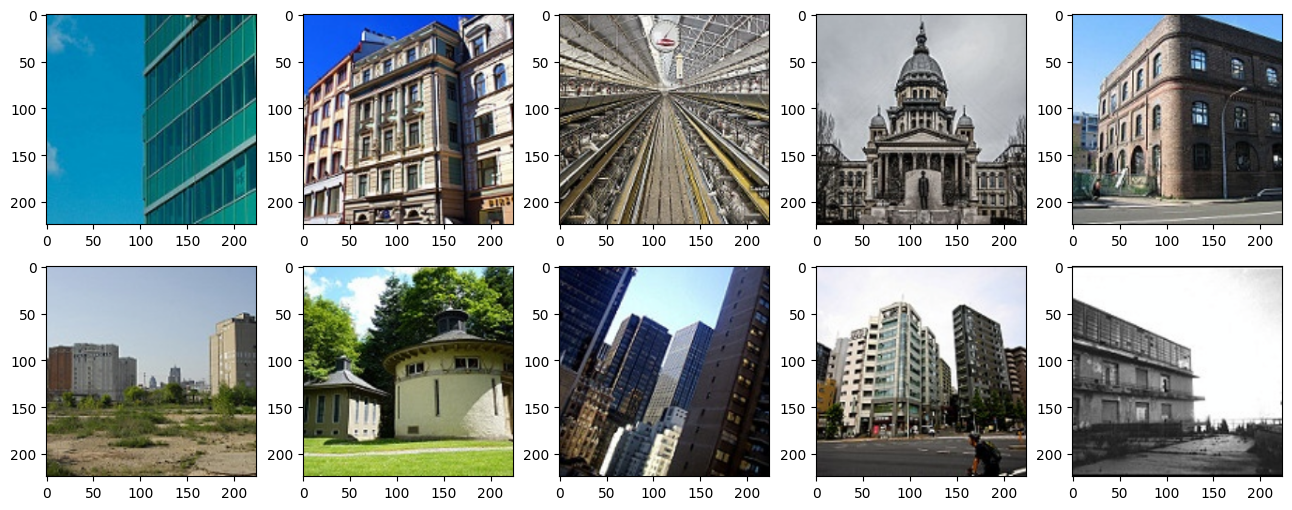

In [5]:
# show some images
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = test_loader.dataset.__getitem__(i)
    image= image.permute(1,2,0).numpy()
    image = (image*std)+mean
    plt.imshow(image)

### Training and evaluation loop

In [6]:
# ## Creating training loop
def train(model):
    model.train()
    train_loss = 0
    total = 0
    correct=0
    with tqdm(train_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            # send to device
            data, target = data.to(device), target.to(device)
    
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*data.size(0)
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        print(' train loss: {:.4f} accuracy: {:.4f}'.format(train_loss/(batch_idx+1), 100.*correct/total))

In [24]:
best_accuracy = 0.0
def validate(model):
    global best_accuracy
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(val_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)
    
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
        if (100.*correct/total) > best_accuracy:
            print("Saving the best model...")
            best_accuracy = (100.*correct/total)
            torch.save(model.state_dict(), 'best_model.pth')
        print(' val loss: {:.4f} accuracy: {:.4f} best_accuracy: {:.4f}'.format(test_loss/(batch_idx+1), 100.*correct/total, best_accuracy))


### Initialise the model, optimizers, schedulers 

In [25]:
START_seed()
import torchvision.models as models

# model = models.vgg16(pretrained=False)
# model.classifier[-1].out_features = 6
# model.head = nn.Linear(model.head.in_features, 6)

model = models.resnet18(pretrained=False)
# model.classifier[-1].out_features = 6
model.fc = nn.Linear(model.fc.in_features, 6)

print(model)

pytorch_total_params = sum(p.numel() for p in  model.parameters())
print('Number of parameters: {0}'.format(pytorch_total_params))

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr) 


In [27]:
model.to(device)
start = time.time()

for epoch in range(0, epochs):
    print("epoch number: {0}".format(epoch))
    train( model)
    validate(model)
end = time.time()
Total_time=end-start
print('Total training and inference time is: {0}'.format(Total_time))

epoch number: 0


100%|████████████████████████████████████████| 88/88 [00:22<00:00,  3.91batch/s]


 train loss: 163.8798 accuracy: 49.7149


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.49batch/s]


Saving the best model...
 val loss: 1.0765 accuracy: 57.3665 best_accuracy: 57.3665
epoch number: 1


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.77batch/s]


 train loss: 116.0652 accuracy: 66.7231


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.48batch/s]


Saving the best model...
 val loss: 0.8831 accuracy: 65.3737 best_accuracy: 65.3737
epoch number: 2


100%|████████████████████████████████████████| 88/88 [00:22<00:00,  3.85batch/s]


 train loss: 94.8829 accuracy: 73.1023


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.62batch/s]


Saving the best model...
 val loss: 0.7488 accuracy: 73.3452 best_accuracy: 73.3452
epoch number: 3


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.80batch/s]


 train loss: 83.6020 accuracy: 76.4077


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.47batch/s]


 val loss: 0.7594 accuracy: 70.0356 best_accuracy: 73.3452
epoch number: 4


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.81batch/s]


 train loss: 75.5895 accuracy: 78.5638


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.50batch/s]


 val loss: 1.1869 accuracy: 59.8221 best_accuracy: 73.3452
epoch number: 5


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.82batch/s]


 train loss: 70.0739 accuracy: 80.4348


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.66batch/s]


Saving the best model...
 val loss: 0.5638 accuracy: 79.9644 best_accuracy: 79.9644
epoch number: 6


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.77batch/s]


 train loss: 64.5138 accuracy: 81.8514


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.35batch/s]


 val loss: 0.6582 accuracy: 74.9110 best_accuracy: 79.9644
epoch number: 7


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.74batch/s]


 train loss: 60.2124 accuracy: 83.2145


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.37batch/s]


 val loss: 0.8297 accuracy: 70.8897 best_accuracy: 79.9644
epoch number: 8


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.74batch/s]


 train loss: 56.8317 accuracy: 83.8917


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.31batch/s]


 val loss: 0.6295 accuracy: 78.6833 best_accuracy: 79.9644
epoch number: 9


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.74batch/s]


 train loss: 54.7569 accuracy: 84.6846


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.39batch/s]


Saving the best model...
 val loss: 0.5216 accuracy: 81.8149 best_accuracy: 81.8149
epoch number: 10


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.73batch/s]


 train loss: 51.5921 accuracy: 85.6825


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.31batch/s]


Saving the best model...
 val loss: 0.4999 accuracy: 82.1708 best_accuracy: 82.1708
epoch number: 11


100%|████████████████████████████████████████| 88/88 [00:23<00:00,  3.76batch/s]


 train loss: 48.6963 accuracy: 86.2972


100%|████████████████████████████████████████| 22/22 [00:04<00:00,  5.39batch/s]


 val loss: 0.5475 accuracy: 80.9964 best_accuracy: 82.1708
epoch number: 12


100%|████████████████████████████████████████| 88/88 [00:22<00:00,  3.89batch/s]


 train loss: 45.4193 accuracy: 87.4198


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.69batch/s]


 val loss: 0.8245 accuracy: 72.7402 best_accuracy: 82.1708
epoch number: 13


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.31batch/s]


 train loss: 42.7751 accuracy: 88.2662


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.67batch/s]


 val loss: 0.6687 accuracy: 78.1495 best_accuracy: 82.1708
epoch number: 14


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.28batch/s]


 train loss: 40.1272 accuracy: 89.3086


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.73batch/s]


 val loss: 0.5635 accuracy: 80.1779 best_accuracy: 82.1708
epoch number: 15


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.27batch/s]


 train loss: 37.7660 accuracy: 89.9145


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.70batch/s]


 val loss: 0.9205 accuracy: 73.1673 best_accuracy: 82.1708
epoch number: 16


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.27batch/s]


 train loss: 36.0628 accuracy: 90.2976


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.68batch/s]


 val loss: 1.0201 accuracy: 71.8505 best_accuracy: 82.1708
epoch number: 17


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.30batch/s]


 train loss: 34.0525 accuracy: 90.7431


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.79batch/s]


 val loss: 0.6494 accuracy: 78.8256 best_accuracy: 82.1708
epoch number: 18


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.27batch/s]


 train loss: 30.8667 accuracy: 91.8211


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.84batch/s]


Saving the best model...
 val loss: 0.4755 accuracy: 84.6263 best_accuracy: 84.6263
epoch number: 19


100%|████████████████████████████████████████| 88/88 [00:20<00:00,  4.32batch/s]


 train loss: 28.1988 accuracy: 92.5517


100%|████████████████████████████████████████| 22/22 [00:03<00:00,  5.58batch/s]

 val loss: 0.8271 accuracy: 74.6263 best_accuracy: 84.6263
Total training and inference time is: 525.6138753890991


### Test the model 

In [27]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

# Usage example:

# Assuming you have a model, test_loader, and best_model_path defined

best_model_path = 'best_model.pth'  # Replace with the actual path and filename of the best model

test_best_model(model, test_loader, nn.CrossEntropyLoss(), best_model_path)


100%|████████████████████████████████████████| 24/24 [00:12<00:00,  1.89batch/s]

Test loss: 2.0488 Accuracy: 17.50%
